In [1]:
using RxInfer, Distributions, Random, GraphPlot, Cairo, MetaGraphsNext, GraphPPL, GraphViz, Dictionaries, Plots, StableRNGs, LinearAlgebra, StatsPlots, LaTeXStrings, DataFrames, CSV, GLM

# Coin-toss Model

In this example, we are going to perform an exact inference for a coin-toss model that can be represented as:

\begin{align}
    p(\theta) &= \text{Beta}(\theta | a, b)\\
    p(y_i | \theta) &= \text{Bernoulli}(y_i | \theta)
\end{align}

Where $y_i \in \{0, 1\}$ is a binary observation induced by Bernoulli likelihood while $\theta$ is a Beta prior distribution on the parameter of the Bernoulli Likelihood. We are interested in inferring the posterior distribution of $\theta$.

The joint probability is given by the multiplication of the likelihood and the prior, i.e.

\begin{equation}
    p(y_{1:N}, \theta) = p(\theta) \prod_{i=1}^{N} p(y_i | \theta)
\end{equation}

We can specify this model (the joint distribution) using GraphPPL's package syntax.

In [36]:
# GraphPPL.jl export `@model` macro for model specification
# It accepts a regular Julia function and builds an FFG under the hood
@model function coin_model(y, a, b)
    # We endow θ parameter of our model with some prior
    θ ~ Beta(a, b)
    # or, in this particular case, the `Uniform(0.0, 1.0)` prior also works:
    # θ ~ Uniform(0.0, 1.0)

    # We assume that outcome of each coin flip is governed by the Bernoulli distribution
    for i in eachindex(y)
        y[i] ~ Bernoulli(θ)
    end
end

In [37]:
conditioned = coin_model(a = 2.0, b = 7.0) | (y = [ true, false, true ], )

coin_model(a = 2.0, b = 7.0) conditioned on: 
  y = Bool[1, 0, 1]


In [38]:
# `Create` the actual graph of the model conditioned on the data
rxi_model = RxInfer.create_model(conditioned)

ProbabilisticModel{GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}}(GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constv

In [39]:
gppl_model = RxInfer.getmodel(rxi_model)

GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0, GraphPPL.PluginsCollection{Tuple{}}(()), RxInfer.ReactiveMPGraphPPLBackend(), Base.RefValue{Int64}(12))

In [40]:
# Extract the MetaGraphsNext graph - we'll want to simply pass the GraphPPL.Model eventually 
meta_graph = gppl_model.graph

Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0

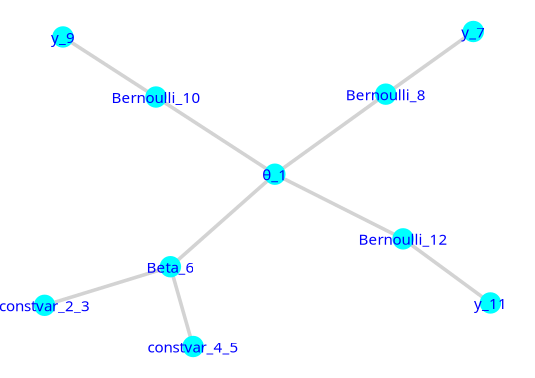

In [41]:
GraphPlot.gplot(
    meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.05, # diameter of the nodes,
    nodelabelc="blue",
    nodelabeldist=0.0,
    nodefillc="cyan",
)

# Linear Regression Model

In [9]:
function generate_data(a, b, v, nr_samples; rng=StableRNG(1234))
    x = float.(collect(1:nr_samples))
    y = a .* x .+ b .+ randn(rng, nr_samples) .* sqrt(v)
    return x, y
end;

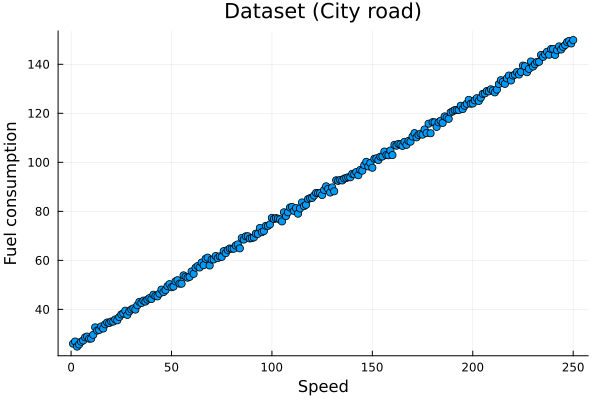

In [10]:
x_data, y_data = generate_data(0.5, 25.0, 1.0, 250)

scatter(x_data, y_data, title = "Dataset (City road)", legend=false)
xlabel!("Speed")
ylabel!("Fuel consumption")

In [55]:
@model function linear_regression(x, y)
    a ~ Normal(mean = 0.0, variance = 1.0)
    b ~ Normal(mean = 0.0, variance = 100.0)    
    y .~ Normal(mean = a .* x .+ b, variance = 1.0)
end

# Prepare the data
x_data = [1.0, 2.0, 3.0, 4.0, 5.0]  # example input data
y_data = [2.0, 4.1, 6.2, 8.3, 10.4]  # example observed data

linr_conditioned = linear_regression() | (x = x_data, y = y_data, )

# Create the RxInfer model and inject the data
linr_rxi_model = GraphPPL.create_model(linr_conditioned)

# Extract the GraphPPL.Model
linr_gppl_model = RxInfer.getmodel(linr_rxi_model)

# Extract the MetaGraphsNext meta graph
linr_meta_graph = linr_gppl_model.graph

GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, linear_regression, "", nothing, {* = 5, NormalMeanVariance = 7, + = 5}, {}, {(NormalMeanVariance, 4) = NormalMeanVariance_48, (+, 2) = +_31, (*, 3) = *_23, (NormalMeanVariance, 7) = NormalMeanVariance_57, (*, 5) = *_27, (*, 1) = *_19, (*, 4) = *_25, (NormalMeanVariance, 3) = NormalMeanVariance_45, (+, 4) = +_35, (NormalMeanVariance, 1) = NormalMeanVariance_6, (NormalMeanVariance, 5) = NormalMeanVariance_51, (NormalMeanVariance, 6) = NormalMeanVariance_54, (NormalMeanVariance, 2) = NormalMeanVariance_1

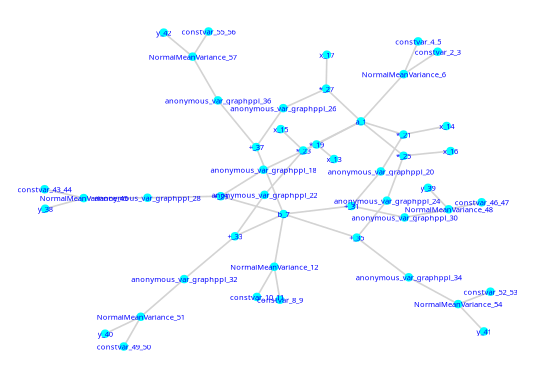

In [69]:
GraphPlot.gplot(
    linr_meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(linr_meta_graph)),
    nodelabelsize=0.1,
    NODESIZE=0.02, # diameter of the nodes,
    NODELABELSIZE=2,
    nodelabelc="blue",
    nodelabeldist=0.0,
    nodefillc="cyan"
)

# Querying The Structure of The Graph

## Contexts

After creating a GraphPPL.Model structure, it is important to know about the attached Context. The Context structure contains all variable and factor nodes in the scope of the model, and contains a Context stucture for all submodels. The context of a model can be accessed by the ```GraphPPL.getcontext()``` function:

In [12]:
fieldnames(GraphPPL.Context)

(:depth, :fform, :prefix, :parent, :submodel_counts, :children, :factor_nodes, :individual_variables, :vector_variables, :tensor_variables, :proxies, :returnval)

In [42]:
gppl_model_context = GraphPPL.getcontext(gppl_model)

Context()
 Individual variables: {:constvar_2, :θ, :constvar_4}
 Vector variables: {:y}
 Tensor variables: {}
 Proxies: {}
 Factor nodes: GraphPPL.FactorID[(Bernoulli, 1), (Bernoulli, 2), (Bernoulli, 3), (Beta, 1)]


In [43]:
function gppl_global_context_info(model::GraphPPL.Model)
    
    context = GraphPPL.getcontext(model)
    
    println("Individual variables: ", context.individual_variables)
    println("Vector variables: ", context.vector_variables)
    println("Tensor variables: ", context.tensor_variables)
    println("Proxies: ", context.proxies)
    println("Factor nodes: ", context.factor_nodes)
    println("Depth: ", context.depth)
    println("Prefix: ", context.prefix)
    println("Parent: ", context.parent)
    println("Submodel counts: ", context.submodel_counts)
    println("Children: ", context.children)
    println("Returnval: ", context.returnval)
    println("------------------------------------- Factor Nodes -------------------------------------")
    
    for factor_node in context.factor_nodes
        node_data = model[factor_node]
        println("Factor Node: ", factor_node)
        println("  Form: ", node_data.properties.fform)
        println("  Neighbors:")
        for (label, edge, neighbor) in node_data.properties.neighbors
            println("    - Label: ", label)
            println("      Edge: ", edge)
            println("      Neighbor: ", neighbor)
            println("      Type of Neighbor: ", typeof(neighbor))
            println()
        end
    end
end

gppl_global_context_info (generic function with 1 method)

In [44]:
for (factor_ID, factor_label) in pairs(gppl_model_context.factor_nodes)
#     println("$(factor_ID), $(factor_label)")
#     println("$(typeof(factor_ID)), $(typeof(factor_label))")
    node_data = gppl_model[factor_label]
    println("$(node_data.properties.fform)\n")
end

Bernoulli

Bernoulli

Bernoulli

Beta



In [45]:
gppl_model_context.factor_nodes

4-element UnorderedDictionary{GraphPPL.FactorID, GraphPPL.NodeLabel}
 (Bernoulli, 1) │ Bernoulli_8
 (Bernoulli, 2) │ Bernoulli_10
 (Bernoulli, 3) │ Bernoulli_12
      (Beta, 1) │ Beta_6

# Inspecting The MetaGraph

In [96]:
meta_graph

Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0

In [53]:
meta_graph[]

Context()
 Individual variables: {:constvar_2, :θ, :constvar_4}
 Vector variables: {:y}
 Tensor variables: {}
 Proxies: {}
 Factor nodes: GraphPPL.FactorID[(Bernoulli, 1), (Bernoulli, 2), (Bernoulli, 3), (Beta, 1)]


In [67]:
fieldnames(GraphPPL.Context)

(:depth, :fform, :prefix, :parent, :submodel_counts, :children, :factor_nodes, :individual_variables, :vector_variables, :tensor_variables, :proxies, :returnval)

In [121]:
methods(GraphPPL.NodeLabel)

# 2 methods for type constructor:
 [1] GraphPPL.NodeLabel(name, global_counter::Int64)
     @ ~/.julia/packages/GraphPPL/BYCRJ/src/graph_engine.jl:193
 [2] GraphPPL.NodeLabel(name, global_counter)
     @ ~/.julia/packages/GraphPPL/BYCRJ/src/graph_engine.jl:193

In [120]:
for label in collect(labels(meta_graph))
    println("$(label): $(typeof(label))")
#     println("$(meta_graph[label]): $(typeof(label.name))")
end

θ_1: GraphPPL.NodeLabel
constvar_2_3: GraphPPL.NodeLabel
constvar_4_5: GraphPPL.NodeLabel
Beta_6: GraphPPL.NodeLabel
y_7: GraphPPL.NodeLabel
Bernoulli_8: GraphPPL.NodeLabel
y_9: GraphPPL.NodeLabel
Bernoulli_10: GraphPPL.NodeLabel
y_11: GraphPPL.NodeLabel
Bernoulli_12: GraphPPL.NodeLabel


In [10]:
collect(labels(meta_graph))

10-element Vector{GraphPPL.NodeLabel}:
 θ_1
 constvar_2_3
 constvar_4_5
 Beta_6
 y_7
 Bernoulli_8
 y_9
 Bernoulli_10
 y_11
 Bernoulli_12

In [102]:
MetaGraphsNext.vertices(meta_graph)

Base.OneTo(10)

In [106]:
collect(labels(meta_graph))

10-element Vector{GraphPPL.NodeLabel}:
 θ_1
 constvar_2_3
 constvar_4_5
 Beta_6
 y_7
 Bernoulli_8
 y_9
 Bernoulli_10
 y_11
 Bernoulli_12

In [110]:
collect(edge_labels(meta_graph))

9-element Vector{Tuple{GraphPPL.NodeLabel, GraphPPL.NodeLabel}}:
 (θ_1, Beta_6)
 (θ_1, Bernoulli_8)
 (θ_1, Bernoulli_10)
 (θ_1, Bernoulli_12)
 (constvar_2_3, Beta_6)
 (constvar_4_5, Beta_6)
 (y_7, Bernoulli_8)
 (y_9, Bernoulli_10)
 (y_11, Bernoulli_12)

In [115]:
MetaGraphsNext.edges(meta_graph)

SimpleEdgeIter 9

In [92]:
fieldnames(GraphPPL.NodeLabel)

(:name, :global_counter)

In [84]:
meta_graph[G]

Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0

In [54]:
typeof(meta_graph)

MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}

In [55]:
typeof(meta_graph[])

GraphPPL.Context

In [116]:
haskey(meta_graph, :θ_1)

false

# GraphViz Visualisations and DOT Code

In [46]:
"""
A helper function to wrap GraphViz DOT code in the 
command string used with GraphViz.jl 
"""
function wrap_dot_code(dot_code::String)
    return "dot\"\"\"\n$dot_code\n\"\"\""
end

wrap_dot_code

In [47]:
function generate_dot_code(gppl_graph::GraphPPL.Model)
    
    graph = gppl_graph.graph
    
    dot_code = "digraph G {node [shape=circle];"

    for vertex in MetaGraphsNext.vertices(graph)
        dot_code *= "    $vertex;"
    end

    for edge in MetaGraphsNext.edges(graph)
        dot_code *= "    $(edge.src) -> $(edge.dst);"
    end

    dot_code *= "}"
    
    wrapped_dot_code = wrap_dot_code(dot_code)
    
    return wrapped_dot_code
end

generate_dot_code (generic function with 1 method)

In [35]:
gppl_model_context

Context()
 Individual variables: {:constvar_2, :θ, :constvar_4}
 Vector variables: {:y}
 Tensor variables: {}
 Proxies: {}
 Factor nodes: GraphPPL.FactorID[(Bernoulli, 1), (Bernoulli, 2), (Bernoulli, 3), (Beta, 1)]


# Operate on the MetaGraph or the GraphPPL.Model?

Iterate through the GraphPPL.Model.graph and the GraphPPL.Model.Context.factor_nodes. If the vertex codes for these match then the GraphPPL.Model.graph vertex under consideration is a factor node. 

In [48]:
# need to get the label from the vertex code

for (factor_id, node_label) in pairs(gppl_model_context.factor_nodes)
#     println("typeof(factor_id): $(typeof(factor_id)), typeof(node_label): $(typeof(node_label))")
#     println("factor_id: $(factor_id), v: $(node_label)")
#     println("$(gppl_model[node_label])\n")
    
    println("$(MetaGraphsNext.code_for(gppl_model.graph, node_label))")
#     println(meta_graph[MetaGraphsNext.code_for(gppl_model.graph, node_label)])
end
    

6
8
10
4


In [76]:
@doc GraphPPL.NodeData 

```
NodeData(context, properties, plugins)
```

Data associated with a node in a probabilistic graphical model.  The `context` field stores the context of the node.  The `properties` field stores the properties of the node.  The `plugins` field stores additional properties of the node depending on which plugins were enabled.


In [49]:
for vertex in MetaGraphsNext.vertices(meta_graph)
    label = MetaGraphsNext.label_for(gppl_model.graph, vertex)
    println("$(typeof(gppl_model[label].properties))\n")
end

GraphPPL.VariableNodeProperties

GraphPPL.VariableNodeProperties

GraphPPL.VariableNodeProperties

GraphPPL.FactorNodeProperties{GraphPPL.NodeData}

GraphPPL.VariableNodeProperties

GraphPPL.FactorNodeProperties{GraphPPL.NodeData}

GraphPPL.VariableNodeProperties

GraphPPL.FactorNodeProperties{GraphPPL.NodeData}

GraphPPL.VariableNodeProperties

GraphPPL.FactorNodeProperties{GraphPPL.NodeData}



In [50]:
for vertex in MetaGraphsNext.vertices(meta_graph)
    label = MetaGraphsNext.label_for(gppl_model.graph, vertex)
    if isa(gppl_model[label].properties, GraphPPL.FactorNodeProperties{GraphPPL.NodeData})
        println("$(gppl_model[label])\n")
    end
end

NodeData in context  with properties fform = Beta, neighbors = Tuple{GraphPPL.NodeLabel, GraphPPL.EdgeLabel, GraphPPL.NodeData}[(θ_1, out, NodeData in context  with properties name = θ, index = nothing), (constvar_2_3, a, NodeData in context  with properties name = constvar_2, index = nothing), (constvar_4_5, b, NodeData in context  with properties name = constvar_4, index = nothing)]

NodeData in context  with properties fform = Bernoulli, neighbors = Tuple{GraphPPL.NodeLabel, GraphPPL.EdgeLabel, GraphPPL.NodeData}[(y_7, out, NodeData in context  with properties name = y, index = 1), (θ_1, p, NodeData in context  with properties name = θ, index = nothing)]

NodeData in context  with properties fform = Bernoulli, neighbors = Tuple{GraphPPL.NodeLabel, GraphPPL.EdgeLabel, GraphPPL.NodeData}[(y_9, out, NodeData in context  with properties name = y, index = 2), (θ_1, p, NodeData in context  with properties name = θ, index = nothing)]

NodeData in context  with properties fform = Bernoulli,

In [82]:
for vertex in MetaGraphsNext.vertices(meta_graph)
    label = MetaGraphsNext.label_for(gppl_model.graph, vertex)
    println("$(gppl_model[label].properties)\n")
end

name = θ, index = nothing

name = constvar_2, index = nothing

name = constvar_4, index = nothing

fform = Beta, neighbors = Tuple{GraphPPL.NodeLabel, GraphPPL.EdgeLabel, GraphPPL.NodeData}[(θ_1, out, NodeData in context  with properties name = θ, index = nothing), (constvar_2_3, a, NodeData in context  with properties name = constvar_2, index = nothing), (constvar_4_5, b, NodeData in context  with properties name = constvar_4, index = nothing)]

name = y, index = 1

fform = Bernoulli, neighbors = Tuple{GraphPPL.NodeLabel, GraphPPL.EdgeLabel, GraphPPL.NodeData}[(y_7, out, NodeData in context  with properties name = y, index = 1), (θ_1, p, NodeData in context  with properties name = θ, index = nothing)]

name = y, index = 2

fform = Bernoulli, neighbors = Tuple{GraphPPL.NodeLabel, GraphPPL.EdgeLabel, GraphPPL.NodeData}[(y_9, out, NodeData in context  with properties name = y, index = 2), (θ_1, p, NodeData in context  with properties name = θ, index = nothing)]

name = y, index = 3

ffor

In [51]:
"""
Basic visualisation a GraphPPL.Model with GraphViz.
Isomorphic to the display given by GraphPlot.gplot.
"""
function show_gv_OG(; Model::GraphPPL.Model, font_size::Int)
    
    meta_graph = Model.graph # underlying MetaGraphsNext graph
    
    dot_code = """
    graph G {
        node [shape=circle, fontsize=$(font_size)];
    """

#     for vertex in MetaGraphsNext.vertices(G)  # add nodes
#         dot_code *="    $(MetaGraphsNext.label_for(G, vertex));\n"
#     end
    
    for vertex in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, vertex)
        if isa(Model[label].properties, GraphPPL.FactorNodeProperties{GraphPPL.NodeData})
            dot_code *="    $(MetaGraphsNext.label_for(meta_graph, vertex)) [shape=square];\n"
        elseif isa(Model[label].properties, GraphPPL.VariableNodeProperties{GraphPPL.NodeData})
            dot_code *="    $(MetaGraphsNext.label_for(meta_graph, vertex)) [shape=circle];\n"
        else
            println("ERROR")
        end
    end
    
#     for (factor_id, node_label) in pairs(gppl_model_context.factor_nodes)
#         # get vertex code from the meta graph
#         # test if this vertex code belongs to a node factor 
#         #     if yes, make this node's shape square
#         println("TESTING")
#     end

    for edge in MetaGraphsNext.edges(meta_graph)  # add edges
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        dot_code *= "    $(source_vertex) -- $(dest_vertex);\n"
    end
    
    dot_code *= "}"

    wrapped_dot_code = wrap_dot_code(dot_code)
    
    eval(Meta.parse(wrapped_dot_code)) # not ideal 

end

show_gv_OG

# Current GraphViz Functionality Demo

# Coin-toss Model

In this example, we are going to perform an exact inference for a coin-toss model that can be represented as:

\begin{align}
    p(\theta) &= \text{Beta}(\theta | a, b)\\
    p(y_i | \theta) &= \text{Bernoulli}(y_i | \theta)
\end{align}

Where $y_i \in \{0, 1\}$ is a binary observation induced by Bernoulli likelihood while $\theta$ is a Beta prior distribution on the parameter of the Bernoulli Likelihood. We are interested in inferring the posterior distribution of $\theta$.

The joint probability is given by the multiplication of the likelihood and the prior, i.e.

\begin{equation}
    p(y_{1:N}, \theta) = p(\theta) \prod_{i=1}^{N} p(y_i | \theta)
\end{equation}

We can specify this model (the joint distribution) using GraphPPL's package syntax.

In [86]:
# GraphPPL.jl export `@model` macro for model specification
# It accepts a regular Julia function and builds an FFG under the hood
@model function coin_model(y, a, b)
    # We endow θ parameter of our model with some prior
    θ ~ Beta(a, b)
    # or, in this particular case, the `Uniform(0.0, 1.0)` prior also works:
    # θ ~ Uniform(0.0, 1.0)

    # We assume that outcome of each coin flip is governed by the Bernoulli distribution
    for i in eachindex(y)
        y[i] ~ Bernoulli(θ)
    end
end

In [87]:
# `Create` the actual graph of the model conditioned on the data
rxi_model = RxInfer.create_model(conditioned)

ProbabilisticModel{GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}}(GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constv

In [88]:
gppl_model = RxInfer.getmodel(rxi_model)

GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0, GraphPPL.PluginsCollection{Tuple{}}(()), RxInfer.ReactiveMPGraphPPLBackend(), Base.RefValue{Int64}(12))

In [89]:
# Extract the MetaGraphsNext graph
meta_graph = gppl_model.graph

Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0

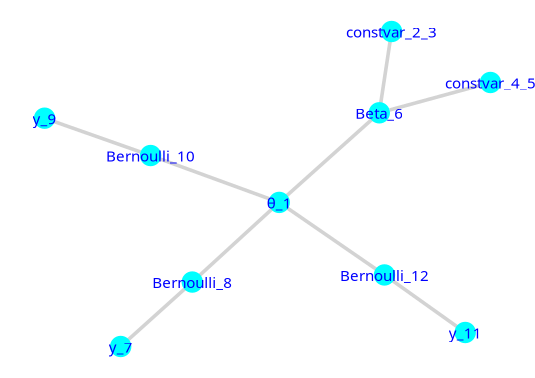

In [102]:
# The existing plotting functionality:
GraphPlot.gplot(
    meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.05, # diameter of the nodes,
    nodelabelc="blue",
    nodelabeldist=0.0,
    nodefillc="cyan",
)

In [92]:
"""
Basic visualisation of a GraphPPL.Model with GraphViz.
Isomorphic to the display given by GraphPlot.gplot.
"""
function show_gv(; Model::GraphPPL.Model, font_size::Int, edge_length::Float64 = 1.0)
    
    meta_graph = Model.graph # underlying MetaGraphsNext graph
    
    dot_code = """
    graph G {
        node [shape=circle, fontsize=$(font_size)];
    """
    
    # Vertices/Nodes
    for vertex in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, vertex)
        
        properties = Model[label].properties # for dsistnguishing factor/variable nodes
        
        if isa(properties, GraphPPL.FactorNodeProperties) # Factor node
            dot_code *= "    \"$(label)\" [shape=square, style=filled, fillcolor=lightgray];\n"
        elseif isa(properties, GraphPPL.VariableNodeProperties) # Variable Node
            dot_code *= "    \"$(label)\" [shape=circle];\n"
        else
            println("ERROR: Unknown node type for label $(label)")
        end
    end
    
    # Edges
    for edge in MetaGraphsNext.edges(meta_graph)
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        dot_code *= "    \"$(source_vertex)\" -- \"$(dest_vertex)\" [len=$(edge_length)];\n"
    end
    
    dot_code *= "}"

    wrapped_dot_code = wrap_dot_code(dot_code)
    
    eval(Meta.parse(wrapped_dot_code)) # not ideal, but used for this example
end

show_gv

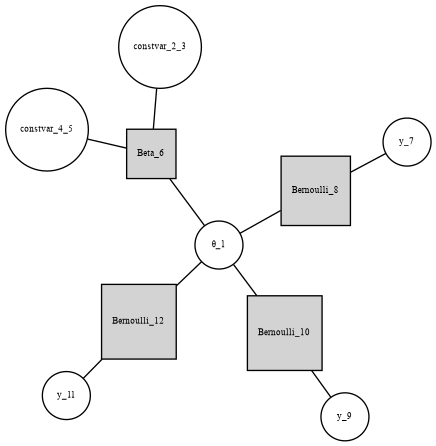

In [103]:
# GraphViz plotting functionality (P.O.C/Work in Progress)
show_gv(
    Model = gppl_model, 
    font_size = 7,
    edge_length = 1.0
)

# Linear Regression Model

In [104]:
function generate_data(a, b, v, nr_samples; rng=StableRNG(1234))
    x = float.(collect(1:nr_samples))
    y = a .* x .+ b .+ randn(rng, nr_samples) .* sqrt(v)
    return x, y
end;

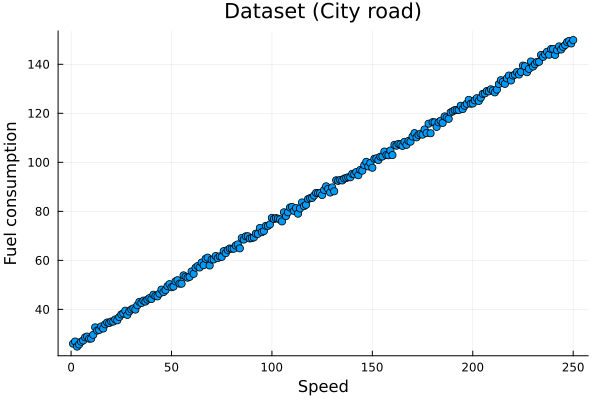

In [95]:
x_data, y_data = generate_data(0.5, 25.0, 1.0, 250)

scatter(x_data, y_data, title = "Dataset (City road)", legend=false)
xlabel!("Speed")
ylabel!("Fuel consumption")

In [55]:
@model function linear_regression(x, y)
    a ~ Normal(mean = 0.0, variance = 1.0)
    b ~ Normal(mean = 0.0, variance = 100.0)    
    y .~ Normal(mean = a .* x .+ b, variance = 1.0)
end

GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, linear_regression, "", nothing, {* = 5, NormalMeanVariance = 7, + = 5}, {}, {(NormalMeanVariance, 4) = NormalMeanVariance_48, (+, 2) = +_31, (*, 3) = *_23, (NormalMeanVariance, 7) = NormalMeanVariance_57, (*, 5) = *_27, (*, 1) = *_19, (*, 4) = *_25, (NormalMeanVariance, 3) = NormalMeanVariance_45, (+, 4) = +_35, (NormalMeanVariance, 1) = NormalMeanVariance_6, (NormalMeanVariance, 5) = NormalMeanVariance_51, (NormalMeanVariance, 6) = NormalMeanVariance_54, (NormalMeanVariance, 2) = NormalMeanVariance_1

In [ ]:
# Prepare the data
x_data = [1.0, 2.0, 3.0, 4.0, 5.0]  # example input data
y_data = [2.0, 4.1, 6.2, 8.3, 10.4]  # example observed data

In [ ]:
linr_conditioned = linear_regression() | (x = x_data, y = y_data, )

In [98]:
# Create the RxInfer model and inject the data
linr_rxi_model = GraphPPL.create_model(linr_conditioned)

ProbabilisticModel{GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}}(GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, linear_regression, "", nothing, {* = 5, NormalMeanVariance = 7, + = 5}, {}, {(NormalMeanVariance, 4) = NormalMeanVariance_48, (+, 2) = +_31, (*, 3) = *_23, (NormalMeanVariance, 7) = NormalMeanVariance_57, (*, 5) = *_27, (*, 1) = 

In [ ]:
# Extract the GraphPPL.Model
linr_gppl_model = RxInfer.getmodel(linr_rxi_model)

In [99]:
# Extract the MetaGraphsNext meta graph
linr_meta_graph = linr_gppl_model.graph

Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, linear_regression, "", nothing, {* = 5, NormalMeanVariance = 7, + = 5}, {}, {(NormalMeanVariance, 4) = NormalMeanVariance_48, (+, 2) = +_31, (*, 3) = *_23, (NormalMeanVariance, 7) = NormalMeanVariance_57, (*, 5) = *_27, (*, 1) = *_19, (*, 4) = *_25, (NormalMeanVariance, 3) = NormalMeanVariance_45, (+, 4) = +_35, (NormalMeanVariance, 1) = NormalMeanVariance_6, (NormalMeanVariance, 5) = NormalMeanVariance_51, (NormalMeanVariance, 6) = NormalMeanVariance_54, (NormalMeanVariance, 2) = NormalMeanVariance_12, (+, 1) = +_29, (+, 5) = +_37, (+, 3) = +_33, (*, 2) = *_21}, {:a = a_1, :b = b_7, :constvar_46 = constvar_46_47, :constvar_55 = constvar_55_56, :anonymous_var_graphppl = anonymous_var_graphppl_36, :constvar_52 = constvar_52_53, :constvar_49 = constvar_49

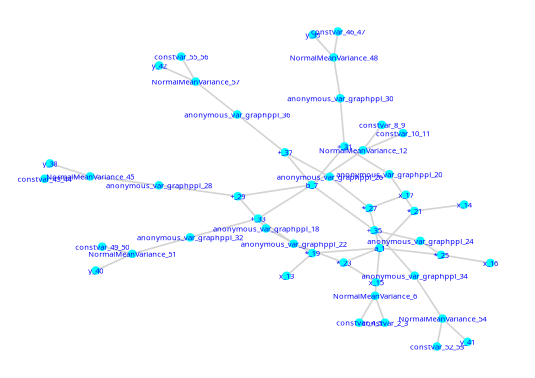

In [105]:
# The existing plotting functionality:
GraphPlot.gplot(
    linr_meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(linr_meta_graph)),
    nodelabelsize=0.1,
    NODESIZE=0.02, # diameter of the nodes,
    NODELABELSIZE=2,
    nodelabelc="blue",
    nodelabeldist=0.0,
    nodefillc="cyan"
)

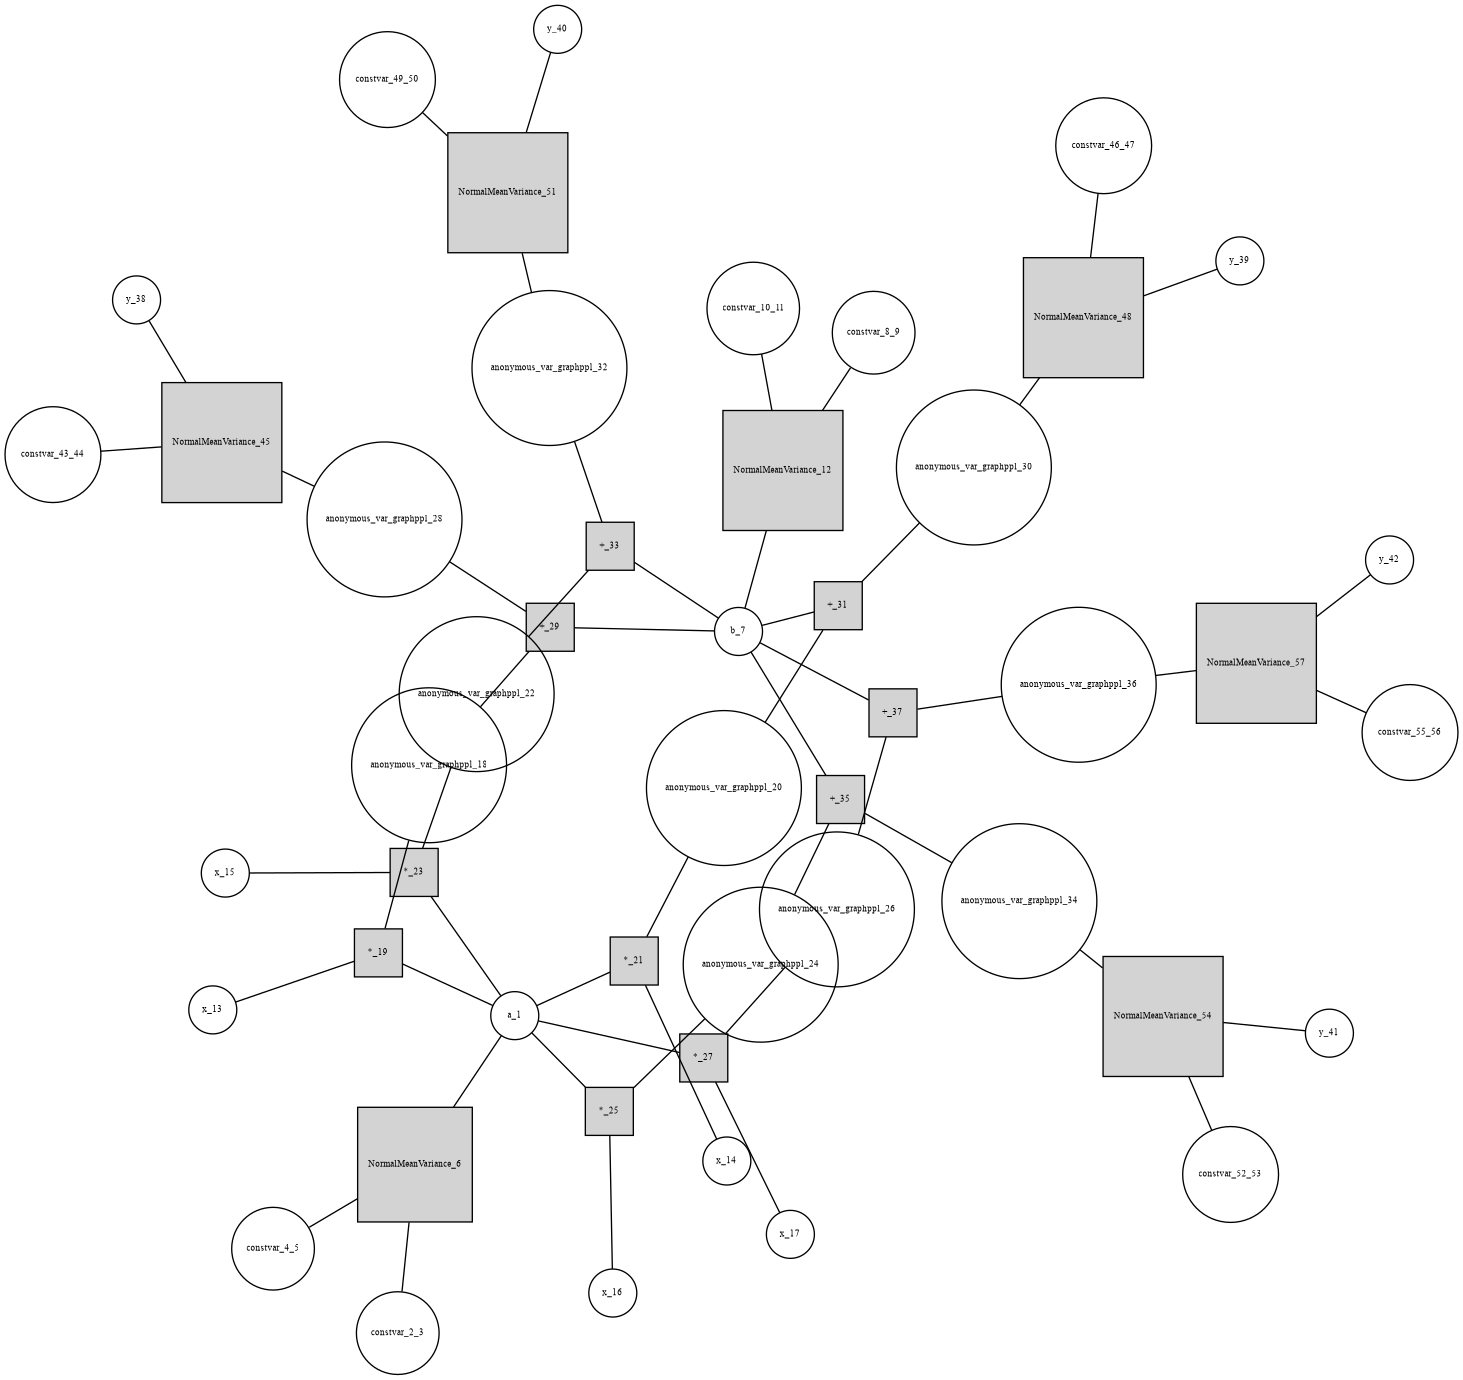

In [106]:
# GraphViz plotting functionality (P.O.C/Work in Progress)
show_gv(
    Model = linr_gppl_model,
    font_size = 7,
    edge_length = 1.5
)

# Tikz/PGF

In [23]:
preamble = """\\documentclass{standalone}
\\usepackage{tikz}
\\usetikzlibrary{graphs,graphdrawing,quotes}
\\usegdlibrary{force}

\\begin{document}
\\begin{tikzpicture}
  \\graph [spring layout, node distance=20mm,
 nodes={draw, circle, fill=blue, text=white},
  edge quotes={fill=yellow, inner sep=2pt}]
  {\n"""

postamble = """};
\\end{tikzpicture}
\\end{document}"""

G = meta_graph

tex_code = preamble

for vertex in MetaGraphsNext.vertices(G)
    tex_code *= "    $(vertex) [as={\$n_{$(vertex)}\$}];\n"
end

for edge in MetaGraphsNext.edges(G)
    source_vertex = MetaGraphsNext.label_for(G, edge.src)
    dest_vertex = MetaGraphsNext.label_for(G, edge.dst)
    tex_code *= "    $(source_vertex) -- $(dest_vertex);\n"
end

tex_code *= postamble

# Write the TikZ code to a .tex file
file_path = "tikz_graph.tex"
open(file_path, "w") do file
    write(file, tex_code)
end

772

In [54]:
for edge in MetaGraphsNext.edges(meta_graph)
    println("$(edge.src)")
    println("$(MetaGraphsNext.label_for(meta_graph, edge.src))\n")
#     dot_code *= "    $(edge.src) -> $(edge.dst);"
end

1
θ_1

1
θ_1

1
θ_1

1
θ_1

2
constvar_2_3

3
constvar_4_5

5
y_7

7
y_9

9
y_11



In [55]:
for edge in MetaGraphsNext.edges(meta_graph)
    println("$(edge.dst)")
    println("$(MetaGraphsNext.label_for(meta_graph, edge.src))\n")
#     dot_code *= "    $(edge.src) -> $(edge.dst);"
end

4
Beta_6

6
Bernoulli_8

8
Bernoulli_10

10
Bernoulli_12

4
Beta_6

4
Beta_6

6
Bernoulli_8

8
Bernoulli_10

10
Bernoulli_12



In [27]:
typeof(MetaGraphsNext.edges(meta_graph))

Graphs.SimpleGraphs.SimpleEdgeIter{Graphs.SimpleGraphs.SimpleGraph{Int64}}

In [33]:
MetaGraphsNext.label_for(meta_graph, 1)

GraphPPL.NodeLabel

In [39]:
for i in 1:length(collect(labels(meta_graph)))
    println(MetaGraphsNext.label_for(meta_graph, i))
end

θ_1
constvar_2_3
constvar_4_5
Beta_6
y_7
Bernoulli_8
y_9
Bernoulli_10
y_11
Bernoulli_12


In [40]:
collect(labels(meta_graph))

10-element Vector{GraphPPL.NodeLabel}:
 θ_1
 constvar_2_3
 constvar_4_5
 Beta_6
 y_7
 Bernoulli_8
 y_9
 Bernoulli_10
 y_11
 Bernoulli_12

In [44]:
for vertex in MetaGraphsNext.vertices(meta_graph)  # add nodes
    println(MetaGraphsNext.label_for(meta_graph, vertex))
end

θ_1
constvar_2_3
constvar_4_5
Beta_6
y_7
Bernoulli_8
y_9
Bernoulli_10
y_11
Bernoulli_12
